In [1]:
import numpy as np
import torch.nn as nn
import torch
from matplotlib import pyplot as plt
from torch import optim
from torch.utils import data
from tqdm import tqdm

In [2]:
N = 100  # number of samples
L = 1000  # length of each sample (number of values for each sine wave)
T = 20  # width of the wave
x = np.empty((N, L), np.float32)  # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
y = np.sin(x / 1.0 / T).astype(np.float32)

x = torch.tensor(np.arange(L) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1), dtype=torch.float32).unsqueeze(-1)
y = torch.sin(x / T)

# Train LSTM

In [8]:
def create_train_data(x: torch.Tensor, y: torch.Tensor, window_size, stride=1, single_y=True):
    """
    B = number of sequences
    L = sequence length
    F = number features
    :param x: shape B,L,F if batched, else L,F
    :param y: shape B,L if batched, else L
    :param window_size:
    :param stride:
    :return: x with shape: N,window_size,F; y with shape: N,1
    """
    batched = x.ndim == 3

    x_out = x.unfold(x.ndim - 2, window_size, stride)
    x_out = x_out.swapaxes(x_out.ndim - 2, x_out.ndim - 1)

    y2 = y.unfold(x.ndim - 2, window_size, stride)

    if batched:
        y_out = y2[:, :, :, -1] if single_y else y2.swapaxes(y2.ndim - 2, y2.ndim - 1)
        y_out = y_out.flatten(0, 1)
        x_out = x_out.flatten(0, 1)
    else:
        y_out = y2[:, :, -1] if single_y else y2.swapaxes(y2.ndim - 2, y2.ndim - 1)

    return x_out, y_out

In [9]:
from lstm import LSTMTest

lstm = LSTMTest()
# o, (h, c) = lstm.forward(y[:-1])
# lstm.n_step(o[-1], h, c, 10)

x_o, y_o = create_train_data(y[:, :-1], y[:, 1:], 300, 1, False)


dataset = data.TensorDataset(x_o, y_o)
# dataset = data.TensorDataset(y[:, :-1], y[:, 1:])
train_loader = data.DataLoader(dataset, shuffle=True, batch_size=256)

epochs = 15
loss_fn = nn.MSELoss()
optimizer = optim.LBFGS(lstm.parameters(), lr=0.08)
for epoch in range(epochs):
    for batch in tqdm(train_loader):
        inputs, targets = batch

        def closure():
            optimizer.zero_grad()
            out, _ = lstm(inputs)
            loss = loss_fn(out, targets)
            loss.backward()
            return loss

        optimizer.step(closure)

    x_test = torch.tensor(np.arange(1000), dtype=torch.float32).unsqueeze(-1)
    y_test = torch.sin(x_test / T)

    fig = lstm.test_and_plot(y_test[:-1], y_test[1:], n_steps=1000)
    fig.suptitle(f"Epoch {epoch}")
    plt.show()

  2%|▏         | 5/274 [00:58<52:50, 11.79s/it]


KeyboardInterrupt: 

# Train Linear

In [3]:
def create_train_data2(x: torch.Tensor, y: torch.Tensor, L, T, stride=1):
    """
    B = number of sequences
    L = sequence length
    F = number features
    :param x: shape B,L,F if batched, else L,F
    :param y: shape B,L if batched, else L
    :param window_size:
    :param stride:
    :return: x with shape: N,window_size,F; y with shape: N,1
    """
    batched = x.ndim == 3

    window_size = L + T

    x_out = x.unfold(x.ndim - 2, window_size, stride)
    x_out = x_out.swapaxes(x_out.ndim - 2, x_out.ndim - 1)

    y2 = y.unfold(x.ndim - 2, window_size, stride)

    if batched:
        y_out = y2.swapaxes(y2.ndim - 2, y2.ndim - 1)
        y_out = y_out.flatten(0, 1)
        x_out = x_out.flatten(0, 1)
        y_out = y_out[:, -T:, :]
        x_out = x_out[:, :L, :]
    else:
        y_out = y2.swapaxes(y2.ndim - 2, y2.ndim - 1)
        y_out = y_out[-T:, :]
        x_out = x_out[:L, :]

    return x_out, y_out

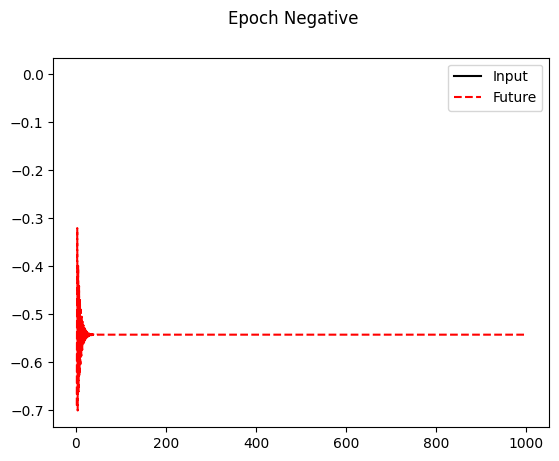

100%|██████████| 390/390 [00:02<00:00, 152.26it/s]


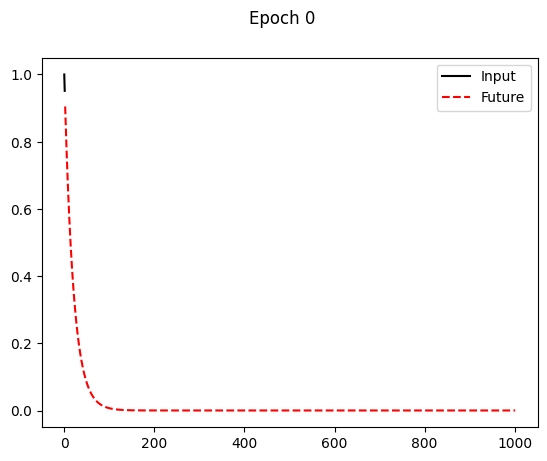

100%|██████████| 390/390 [00:02<00:00, 191.83it/s]


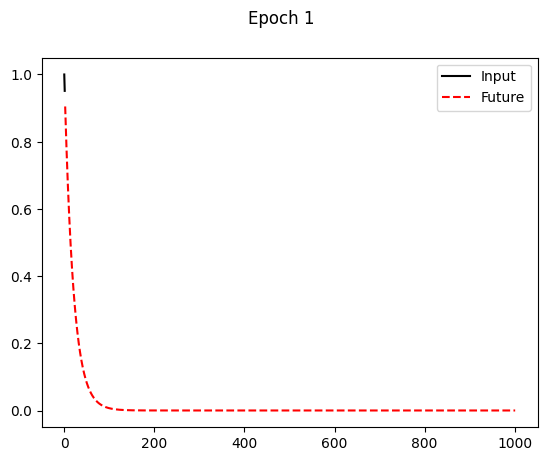

100%|██████████| 390/390 [00:02<00:00, 154.23it/s]


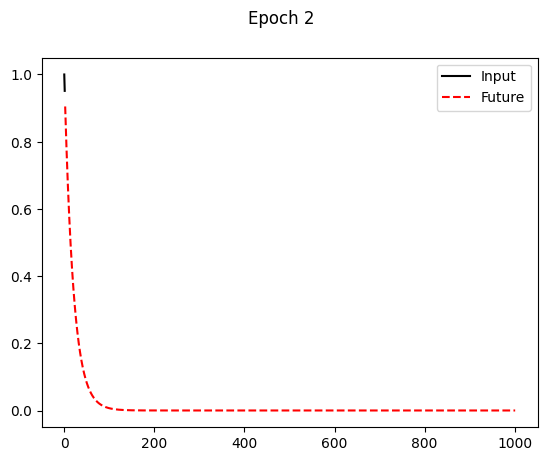

 42%|████▏     | 165/390 [00:01<00:01, 143.32it/s]


KeyboardInterrupt: 

In [25]:
from LTSF_Linear import *

Li = 2
Ti = 1

def fn(x):
    return torch.exp(-x / T)

N = 100  # number of samples
L = 1000  # length of each sample (number of values for each sine wave)
T = 20  # width of the wave
x = np.empty((N, L), np.float32)  # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)

x = torch.tensor(np.arange(L) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1), dtype=torch.float32).unsqueeze(-1)
y = fn(x)

model = LTSFLinear(Li, Ti, 1, 1)

x_o, y_o = create_train_data2(y, y, Li, Ti, 1)

dataset = data.TensorDataset(x_o, y_o.squeeze(-1))
# dataset = data.TensorDataset(y[:, :-1], y[:, 1:])
train_loader = data.DataLoader(dataset, shuffle=True, batch_size=256)

x_test = torch.tensor(np.arange(1000), dtype=torch.float32).unsqueeze(-1)
y_test = fn(x_test)

fig = model.test_and_plot(y_test[-Li:], y_test[-Li:], n_steps=1000)
fig.suptitle(f"Epoch Negative")
plt.show()

epochs = 15
loss_fn = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.08)
for epoch in range(epochs):
    for batch in tqdm(train_loader):
        inputs, targets = batch

        def closure():
            optimizer.zero_grad()
            out = model(inputs)
            loss = loss_fn(out, targets)
            loss.backward()
            return loss

        optimizer.step(closure)

    x_test = torch.tensor(np.arange(1000), dtype=torch.float32).unsqueeze(-1)
    y_test = fn(x_test)

    fig = model.test_and_plot(y_test[:Li], y_test[:Li], n_steps=1000)
    fig.suptitle(f"Epoch {epoch}")
    plt.show()

In [30]:
y_test.shape

torch.Size([1000, 1])

tensor([[-0.9904, -0.5786]], grad_fn=<LogBackward0>)

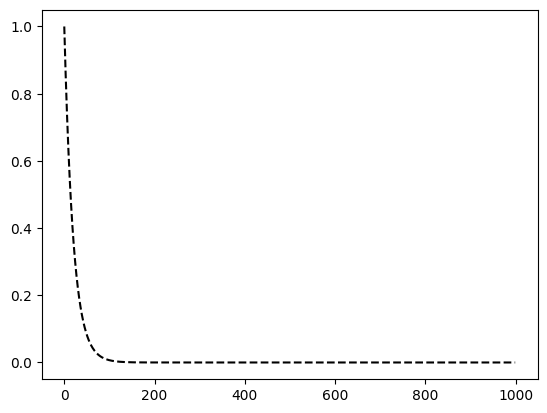

In [29]:
preds = model.n_step(y_test[:Li], 1000)
x2 = np.arange(1000) + 2
ytarg = np.exp(-x2/T)

yplt = [t.item() for t in preds]
plt.plot(x_test.tolist(), y_test.tolist(), 'k-')
# plt.plot(x2, yplt, 'r--')